<a href="https://colab.research.google.com/github/adhikaribibek231/MachineLearning/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

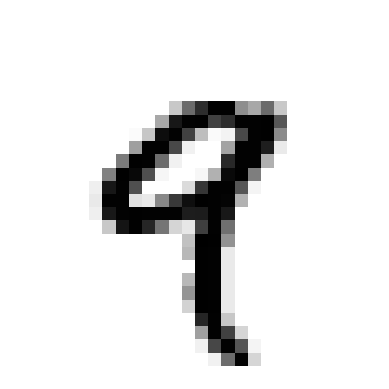

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X.iloc[4]
some_digit_image=some_digit.to_numpy().reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [7]:
y[4]

'9'

In [8]:
y= y.astype(np.uint8)

In [9]:
# Train test split, in MNIST the data set is already shuffled and split
X_train, X_test, y_train, y_test =  X[:60000], X[60000:],y[:60000],y[60000:]

In [10]:
#training a binary classifier
# lets just identify one digit, the number 9
#Lets create target vectors for this classification task
y_train_9 = (y_train == 9) #true for all 9s, false for all other digits
y_test_9 = (y_test == 9)

In [11]:
#we ue stochastic gradient descent)SGD) classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])
# Looks like it guessed right in this particular case!

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [13]:
#performance measures
#measuring accuracy using cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits= 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_9):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_9.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_9.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.94065
0.94405
0.94885


In [14]:
#shortcut way
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring = 'accuracy')

array([0.9456 , 0.95195, 0.9509 ])

In [15]:
# Now let's create a very simple (and dumb) classifier
# that predicts "not 9" for every single image.
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
    def fit(self, X,y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_9_clf= Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv= 3, scoring= 'accuracy')

array([0.8993 , 0.8999 , 0.90335])

In [16]:
# This happens because only about 10% of the dataset are 9s → the dataset is imbalanced.


In [17]:
#Confusion Matrix
# A much better way to evaluate the performance of a classifier is to look at the confusion matrix.
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[52715,  1336],
       [ 1695,  4254]])

In [18]:
# Confusion matrix:
# [[TN, FP],
#  [FN, TP]]
#
# TN = 52715 → correctly classified as "not 9"
# FP = 1336  → wrongly classified as "9" (false alarm)
# FN = 1695  → missed actual "9"s (predicted not 9)
# TP = 4254  → correctly classified as "9"
# A perfect classifier would have only true positives and true negatives

In [19]:
y_train_perfect_predictions = y_train_9 #pretend we reached perfection
confusion_matrix(y_train_9, y_train_perfect_predictions)

array([[54051,     0],
       [    0,  5949]])

In [20]:
#precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_9, y_train_pred) # 4254 / (4254 + 1336)

0.7610017889087657

In [21]:
recall_score(y_train_9, y_train_pred) # 4254 / (4254 + 1695)

0.7150781643973777

In [22]:
#combine precision and recall into a single score called F1 score
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.737325591472398

In [23]:
#precision/recall tradeoff
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([1468.75336355])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
# This confirms that raising the threshold decreases recall.
# Now how do you decide which threshold to use?
# Convert y_train to binary for "is digit 9?"
y_train_9_binary = (y_train == 9)

# Get decision scores using the binary target
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9_binary, cv=3, method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

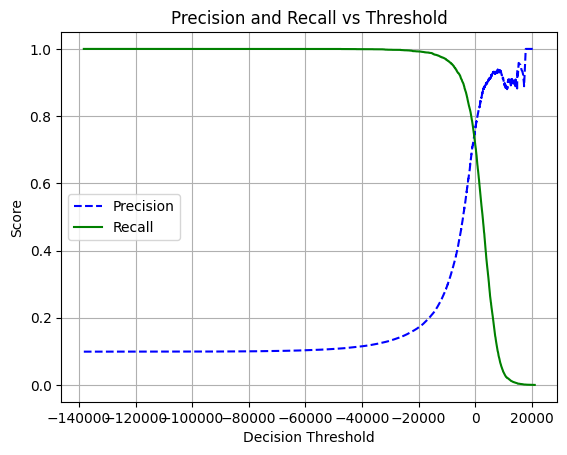

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Threshold")
    plt.legend()
    plt.grid(True)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_9, y_train_pred_90)

0.9001728608470182

In [32]:
recall_score(y_train_9, y_train_pred_90)

0.3501428811564969

In [33]:
#The ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

/tmp/ipython-input-1818561254.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


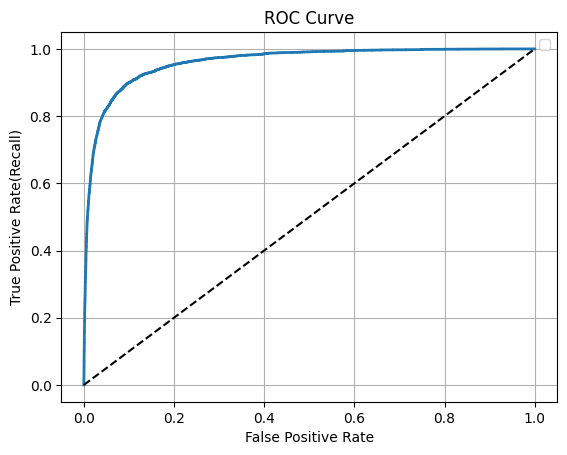

In [34]:
def plot_roc_curve(fpr, tpr, label= None):
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate(Recall)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
plot_roc_curve(fpr,tpr)
plt.show()

In [35]:
#Once again there is a tradeoff. The higher the recall, the more false positives the classifier produces.

In [36]:
from sklearn.metrics import roc_auc_score
#Area under the curve(AUC)
roc_auc_score(y_train_9, y_scores)

np.float64(0.96114559368217)

In [37]:
#lets train a randomforestclassifier and compare its ROC curve and ROC AUC score to the SGDClassifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state= 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv= 3, method = "predict_proba")

In [39]:
#but to plot ROC curve, you need scores, not probabilities. a simple solution is to use the positive class's probability as score
y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

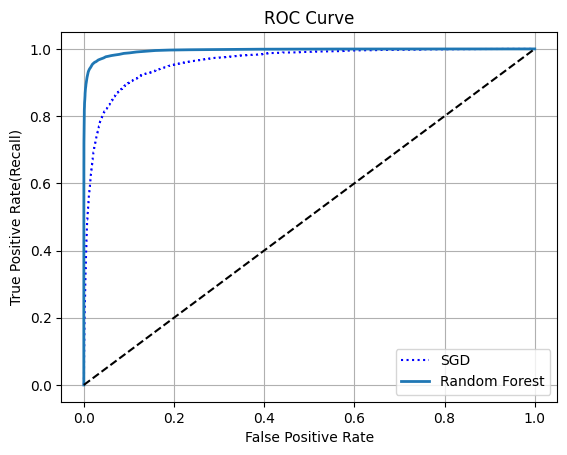

In [40]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [41]:
roc_auc_score(y_train_9, y_scores_forest)

np.float64(0.9952328942154235)

In [42]:
# multiclass classification
sgd_clf.fit(X_train, y_train) #y_train not y_train_9
sgd_clf.predict([some_digit])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([9], dtype=uint8)

In [43]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-45606.88156161, -20077.79903687, -23620.86693862,
        -11077.35532351,  -8578.08720996,  -7133.8897717 ,
        -27033.93740198,  -8312.88994614,  -3257.29010483,
          2193.22821614]])

In [44]:
np.argmax(some_digit_scores)

np.int64(9)

In [45]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
sgd_clf.classes_[9]

np.uint8(9)

In [47]:
# For one v one
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([9], dtype=uint8)

In [48]:
len(ovo_clf.estimators_)

45

In [49]:
# training a randomforestclassifier is just as easy
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([9], dtype=uint8)

In [50]:
forest_clf.predict_proba([some_digit])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.01, 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.02, 0.95]])

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv= 3, scoring= "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

In [54]:
#Error analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx= confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

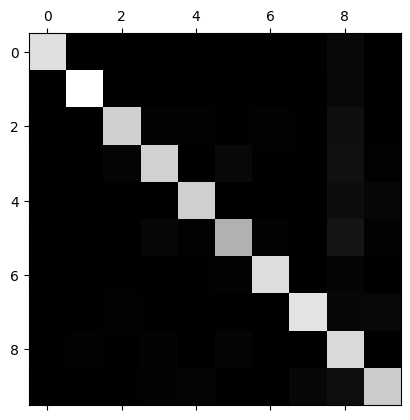

In [55]:
plt.matshow(conf_mx, cmap= plt.cm.gray)
plt.show()

In [56]:
# Let’s focus the plot on the errors. First, you need to divide each value in the confusion
# matrix by the number of images in the corresponding class, so you can compare error
# rates instead of absolute number of errors (which would make abundant classes look unfairly bad):
row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

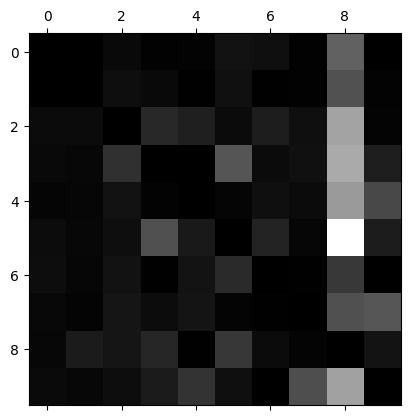

In [57]:
# Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

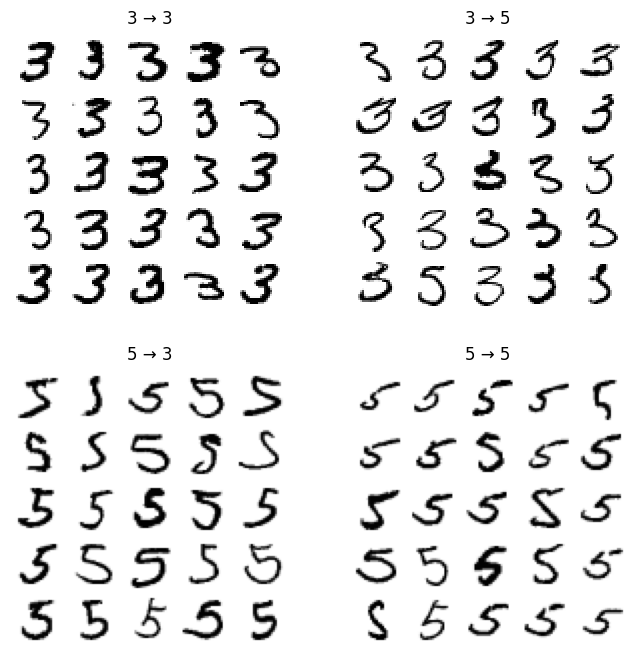

In [61]:
# Analyzing individual errors can also be a good way to gain insights on what your
# classifier is doing and why it is failing, but it is more difficult and time-consuming.
# For example, let’s plot examples of 3s and 5s (the plot_digits() function just uses
# Matplotlib’s imshow() function; see this chapter’s Jupyter notebook for details):

# assume X_train has shape (n_samples, 784), y_train = true labels, y_train_pred = predicted labels

cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# convert to numpy arrays if they are DataFrames
if not isinstance(X_aa, np.ndarray):
    X_aa = X_aa.to_numpy()
    X_ab = X_ab.to_numpy()
    X_ba = X_ba.to_numpy()
    X_bb = X_bb.to_numpy()

# helper to tile several digit images in one panel
def plot_digits(instances, images_per_row=5, **options):
    size = 28  # MNIST digits are 28x28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    image_grid = padded.reshape((n_rows, images_per_row, size, size))
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    plt.imshow(big_image, cmap="binary", **options)
    plt.axis("off")

# 2×2 panel, each showing 25 digits
plt.figure(figsize=(8,8))

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5); plt.title("3 → 3")
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5); plt.title("3 → 5")
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5); plt.title("5 → 3")
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5); plt.title("5 → 5")

plt.show()


In [62]:
# The two 5×5 blocks on the left show digits classified as 3s,
# and the two 5×5 blocks on the right show images classified as 5s

In [63]:
#multilabel classification
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [64]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[ True,  True]])

In [65]:
# And it gets it right! The digit 9 is indeed large (True) and odd (True).

In [66]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel,cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [67]:
#multioutput classification
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


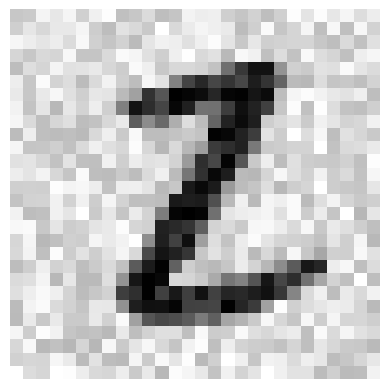

In [75]:
# If X_test_mod is a DataFrame, convert to numpy
X_test_mod = np.array(X_test_mod)
y_test_mod = np.array(y_test_mod)

# Now you can safely index
some_index = 3600
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

# Plot the digit correctly
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)  # MNIST digits are 28x28
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    plt.show()

plot_digit(X_test_mod[some_index])
# print("Predicted label:", clean_digit[0])